# Tour of hera_sim

This notebook briefly introduces some of the effects that can be modeled with `hera_sim`.

In [43]:
%matplotlib inline
import aipy, uvtools
import numpy as np
import pylab as plt
plt.rcParams['figure.figsize'] = [14, 8]

In [44]:
from hera_sim import foregrounds, noise, sigchain, rfi

In [45]:
from os import path
from hera_sim import DATA_PATH

# These used to be in hera_sim but are not now.

def _check_path(datafile):
    # if the datafile is not an absolute path, assume it's in the data folder
    if not path.isabs(datafile):
        datafile = path.join(DATA_PATH, datafile)
    # make sure that the path exists
    assert path.exists(datafile), \
            "If datafile is not an absolute path, then it is assumed to " \
            "exist in the hera_sim.data folder. The datafile passed could " \
            "not be found; please ensure that the path to the file exists"
    return datafile

def _read_npy(npy):
    return np.load(_check_path(npy))

def _get_hera_bm_poly(bm_poly='HERA_H1C_BEAM_POLY.npy'):
    """
    Method for getting HERA bandpass polynomial coefficients. This should be
    replaced in the future.
    """
    return _read_npy(bm_poly)

def bm_poly_to_omega_p(fqs, bm_poly=None):
    """
    Convert polynomial coefficients to beam area.

    Args:
        fqs (array-like): shape=(NFREQS,), GHz
            frequency array
        bm_poly (polynomial): default=HERA_BEAM_POLY
            a polynomial fit to sky-integral, solid-angle beam size of
            observation as a function of frequency.

    Returns:
        omega_p : (array-like): shape=(NFREQS,), steradian
            sky-integral of peak-normalized beam power
    """
    if bm_poly is None:
        bm_poly = _get_hera_bm_poly()
    return np.polyval(bm_poly, fqs)


In [46]:
fqs = np.linspace(.1,.2,1024,endpoint=False)
lsts = np.linspace(0,2*np.pi,10000, endpoint=False)
times = lsts / (2*np.pi) * aipy.const.sidereal_day
bl_len_ns = np.array([30., 0, 0])

## Foregrounds

### Diffuse Foregrounds

In [47]:
Tsky_mdl = noise.HERA_Tsky_mdl['xx']

vis_fg_diffuse = foregrounds.diffuse_foreground(lsts, fqs, bl_len_ns, Tsky_mdl=Tsky_mdl, omega_p=bm_poly_to_omega_p(fqs))

(0.0, 4000.0)

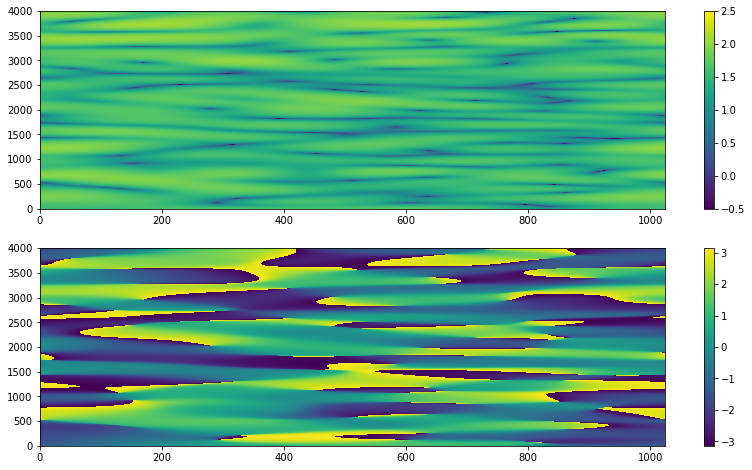

In [48]:
MX, DRNG = 2.5, 3

plt.subplot(211); uvtools.plot.waterfall(vis_fg_diffuse, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg_diffuse, mode='phs'); plt.colorbar(); plt.ylim(0,4000)


### Point-Source Foregrounds

In [49]:
vis_fg_pntsrc = foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)

(0.0, 4000.0)

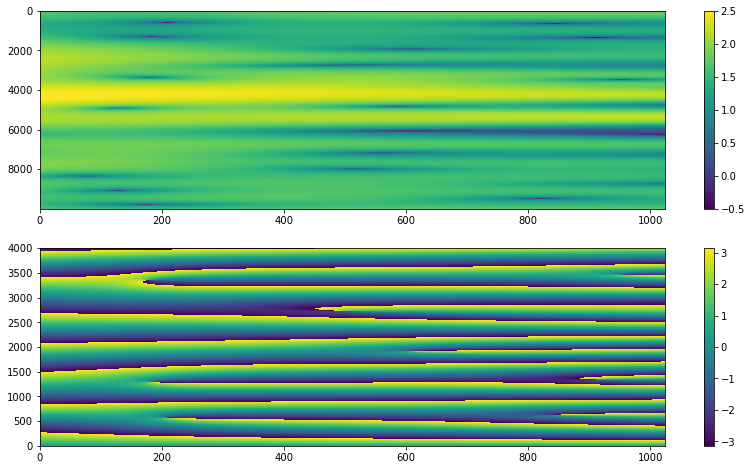

In [50]:
plt.subplot(211); uvtools.plot.waterfall(vis_fg_pntsrc, mode='log', mx=MX, drng=DRNG); plt.colorbar()#; plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg_pntsrc, mode='phs'); plt.colorbar(); plt.ylim(0,4000)


### Diffuse and Point-Source Foregrounds

In [51]:
vis_fg = vis_fg_diffuse + vis_fg_pntsrc

(0.0, 4000.0)

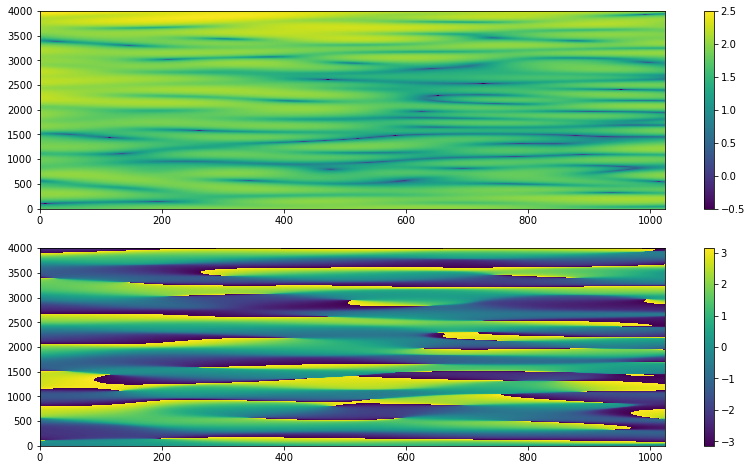

In [52]:
plt.subplot(211); uvtools.plot.waterfall(vis_fg, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg, mode='phs'); plt.colorbar(); plt.ylim(0,4000)


## Noise

In [53]:
tsky = noise.resample_Tsky(fqs,lsts,Tsky_mdl=noise.HERA_Tsky_mdl['xx'])
t_rx = 150.
omega_p = bm_poly_to_omega_p(fqs)
nos_jy = noise.sky_noise_jy(lsts, fqs, omega_p=omega_p)

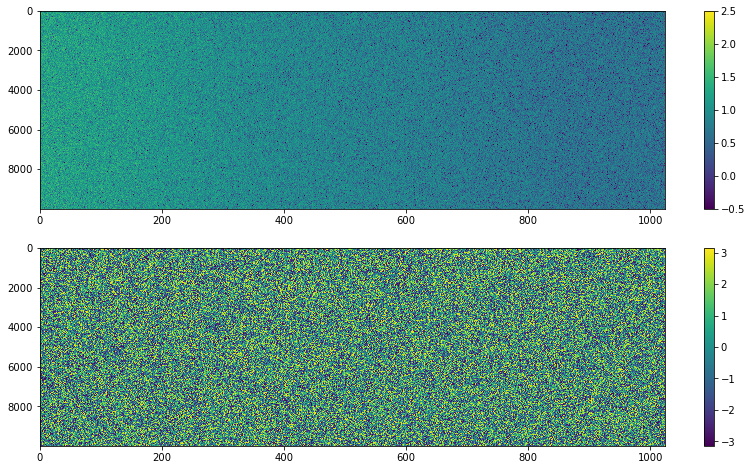

In [54]:
plt.subplot(211); uvtools.plot.waterfall(nos_jy, mode='log', mx=MX, drng=DRNG); plt.colorbar()#; plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(nos_jy, mode='phs'); plt.colorbar()#; plt.ylim(0,4000)


In [55]:
vis_fg_nos = vis_fg + nos_jy

(0.0, 4000.0)

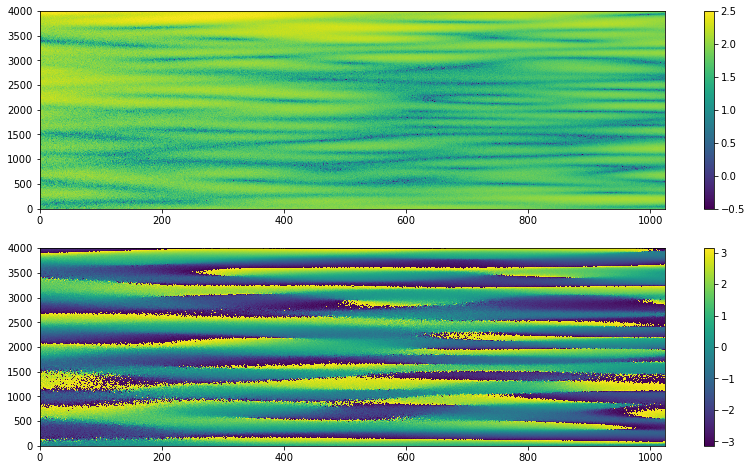

In [56]:
plt.subplot(211); uvtools.plot.waterfall(vis_fg_nos, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg_nos, mode='phs'); plt.colorbar(); plt.ylim(0,4000)


## RFI

In [57]:
rfi1 = rfi.rfi_stations(fqs, lsts)
rfi2 = rfi.rfi_impulse(fqs, lsts, impulse_chance=.02)
rfi3 = rfi.rfi_scatter(fqs, lsts, scatter_chance=.001)
rfi_all = rfi1 + rfi2 + rfi3

/home/hugh_admin/anaconda3_herasim/lib/python3.9/site-packages/hera_sim/rfi.py:167: UserWarning: You did not specify any stations to simulate.
  warnings.warn("You did not specify any stations to simulate.")


/home/hugh_admin/anaconda3_herasim/lib/python3.9/site-packages/uvtools/plot.py:43: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data)


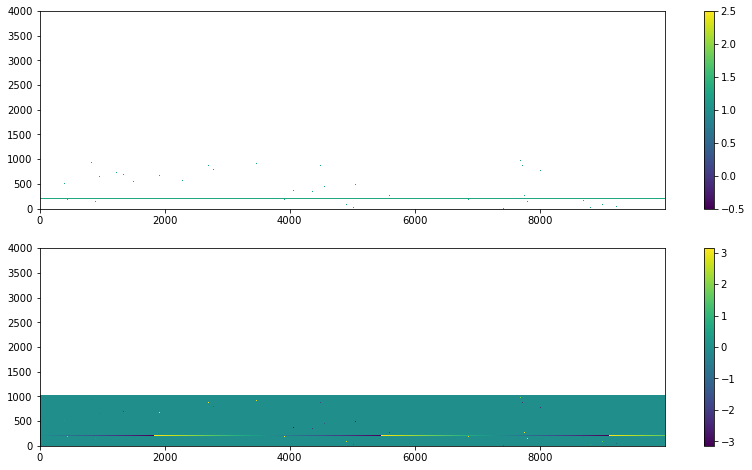

In [58]:
plt.subplot(211); uvtools.plot.waterfall(rfi_all, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(rfi_all, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
plt.show()

In [59]:
vis_fg_nos_rfi = vis_fg_nos + rfi_all.T

(0.0, 4000.0)

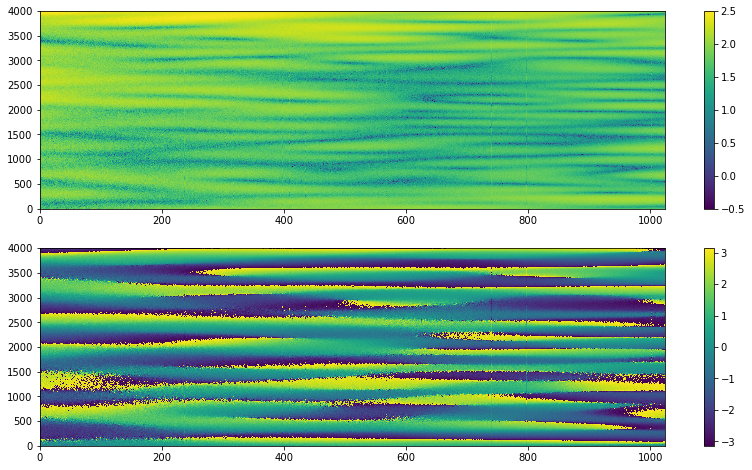

In [60]:
plt.subplot(211); uvtools.plot.waterfall(vis_fg_nos_rfi, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_fg_nos_rfi, mode='phs'); plt.colorbar(); plt.ylim(0,4000)


## Gains

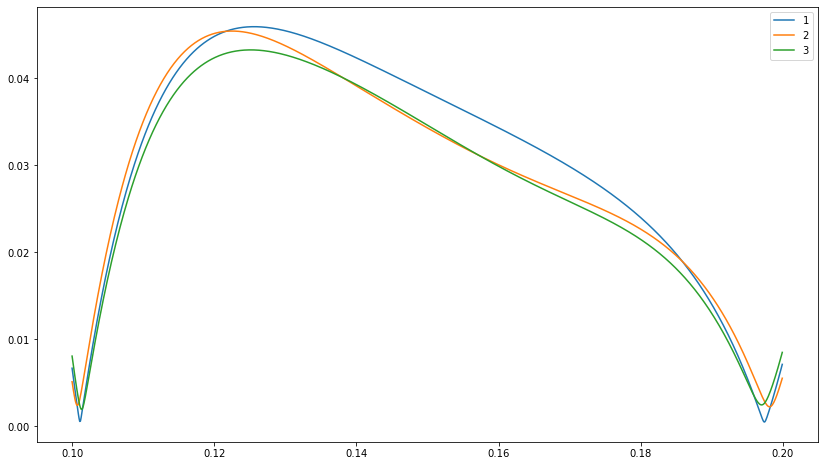

In [61]:
g = sigchain.gen_gains(fqs, [1,2,3])
plt.figure()
for i in g: plt.plot(fqs, np.abs(g[i]), label=str(i))
plt.legend(); plt.show()
gainscale = np.average([np.median(np.abs(g[i])) for i in g])
MXG = MX + np.log10(gainscale)

(0.0, 4000.0)

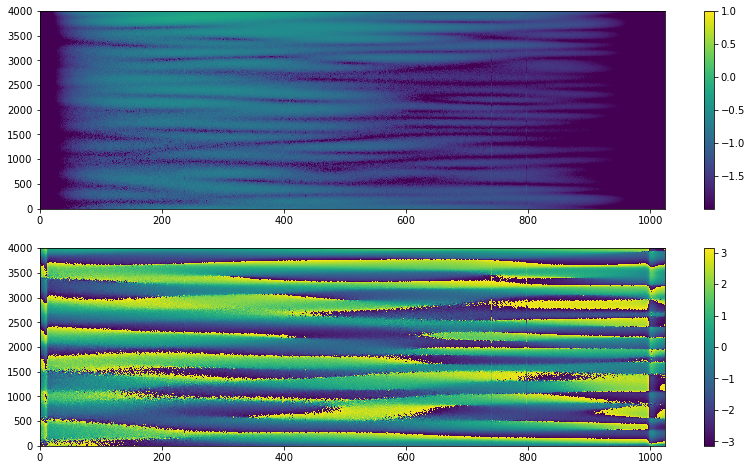

In [62]:
vis_total = sigchain.apply_gains(vis_fg_nos_rfi, g, (1,2))

plt.subplot(211); uvtools.plot.waterfall(vis_total, mode='log', mx=MXG, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_total, mode='phs'); plt.colorbar(); plt.ylim(0,4000)


## Crosstalk

(0.0, 4000.0)

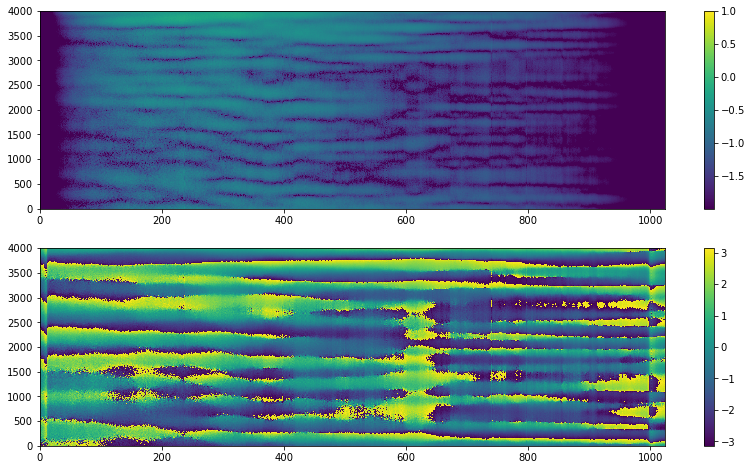

In [63]:
xtalk = sigchain.gen_whitenoise_xtalk(fqs)
if xtalk.ndim == 1:
    xtalk = np.reshape(xtalk, (1, -1))
vis_xtalk = vis_fg_nos_rfi+xtalk
vis_xtalk = sigchain.apply_gains(vis_xtalk, g, (1,2))

plt.subplot(211); uvtools.plot.waterfall(vis_xtalk, mode='log', mx=MXG, drng=DRNG); plt.colorbar(); plt.ylim(0,4000)
plt.subplot(212); uvtools.plot.waterfall(vis_xtalk, mode='phs'); plt.colorbar(); plt.ylim(0,4000)
